# Exploratory notebook
The analysis is based on the Gonzalo-Moser EC paper. 
* 1/28/24 setup
* TODO need to separate the awake and sleep epochs
* using spikes instead of Ca2+ data

In [47]:
import os, sys
from os.path import dirname, join
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
from scipy.stats import zscore

sys.path.append("/home/gergely/code/sleep/src")

from imaging_data_class import ImagingData
from suite2p_class import Suite2p as s2p
import imaging_data_class as idc
import behavior_class as bc

In [27]:
mice = [
    "140302_3"
]  # ["5HT2afl05b_1", "5HT2afl05b_2", "sert52b_1", "sert52b_5", "sert54a_5"]

In [28]:
mouse = ImagingData(mice[0])
mouse.mouse_id
s2p_folders = mouse.find_suite2p_folders()
for folder in enumerate(s2p_folders):
    print(folder)

Searching for suite2p folders in /data2/gergely/invivo_DATA/sleep/140302_3
(0, '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-001/TSeries-12212023-1051-001.sima/suite2p')
(1, '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-002/TSeries-12212023-1051-002.sima/suite2p')
(2, '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess01-001/TSeries-12112023-0825_sess01-001_Cycle00001_Element00001.sima/suite2p')
(3, '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess02_MC-002/TSeries-12112023-0825_sess02_MC-002.sima/suite2p')
(4, '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_MC-003/TSeries-12132023-0849_GC_MC-003.sima/suite2p')
(5, '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_dendrite-004/TSeries-12132023-0849_GC_dendrite-004.sima/suite2p')
(6, '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC-002/TSeries-12132023-0849_GC-002.

In [29]:
s2p_folder = s2p_folders[10]

In [30]:
s2p_data = s2p(s2p_folder)
spikes = s2p_data.get_spikes()
# z scoring
n_neurons, n_time = spikes.shape
spks = zscore(spikes, axis=1)

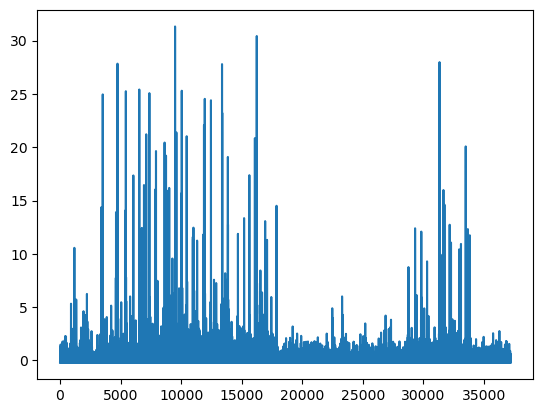

In [37]:
spks_df = pd.DataFrame(spks)
plt.plot(spks_df.iloc[0])

### Behavior

In [40]:
behavior = bc.behaviorData(mouse_id=mice[0])
behavior_folders = [
    (index, folder) for index, folder in enumerate(behavior.find_behavior_folders())
]
behavior_folders

Searching for behavior folders in /data2/gergely/invivo_DATA/sleep/140302_3
Searching for behavior folders in /data2/gergely/invivo_DATA/sleep/140302_3


[(0,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-001/TSeries-12212023-1051-001.sima/behavior'),
 (1,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-002/TSeries-12212023-1051-002.sima/behavior'),
 (2,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess01-001/TSeries-12112023-0825_sess01-001_Cycle00001_Element00001.sima/behavior'),
 (3,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess02_MC-002/TSeries-12112023-0825_sess02_MC-002.sima/behavior'),
 (4,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_MC-003/TSeries-12132023-0849_GC_MC-003.sima/behavior'),
 (5,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_dendrite-004/TSeries-12132023-0849_GC_dendrite-004.sima/behavior'),
 (6,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC-002/TSeries-12132023-0849_GC-002.sima/behavior'),
 (7,
  '/data2/gergely/in

In [41]:
beh_folder_to_load = 10
behavior_file = "140302_3_20231222154006_910_sleep.json"

In [48]:
processed_behavior = behavior_folders[beh_folder_to_load][1]

if not dirname(processed_behavior) == dirname(s2p_folder):
    raise ValueError("Behavior and imaging data folders do not match")

try:
    with open(join(processed_behavior, behavior_file), "r") as f:
        beh = json.load(f)
except FileNotFoundError:
    print("File not found")

In [49]:
with open(join(processed_behavior, "filtered_velocity.json"), "r") as f:
    speed = np.array(json.load(f))

position = np.array(beh[0]["data"]["treadmillPosition"])

with open(join(processed_behavior, "mobility_immobility.json"), "r") as f:
    mob_immob = np.array(json.load(f))

In [51]:
moving_spks = pd.DataFrame(spks[:, mob_immob == 1])
notmoving_spks = pd.DataFrame(spks[:, ~mob_immob == 1])

## Calcluates and plots the autocorrelation of the traces. 

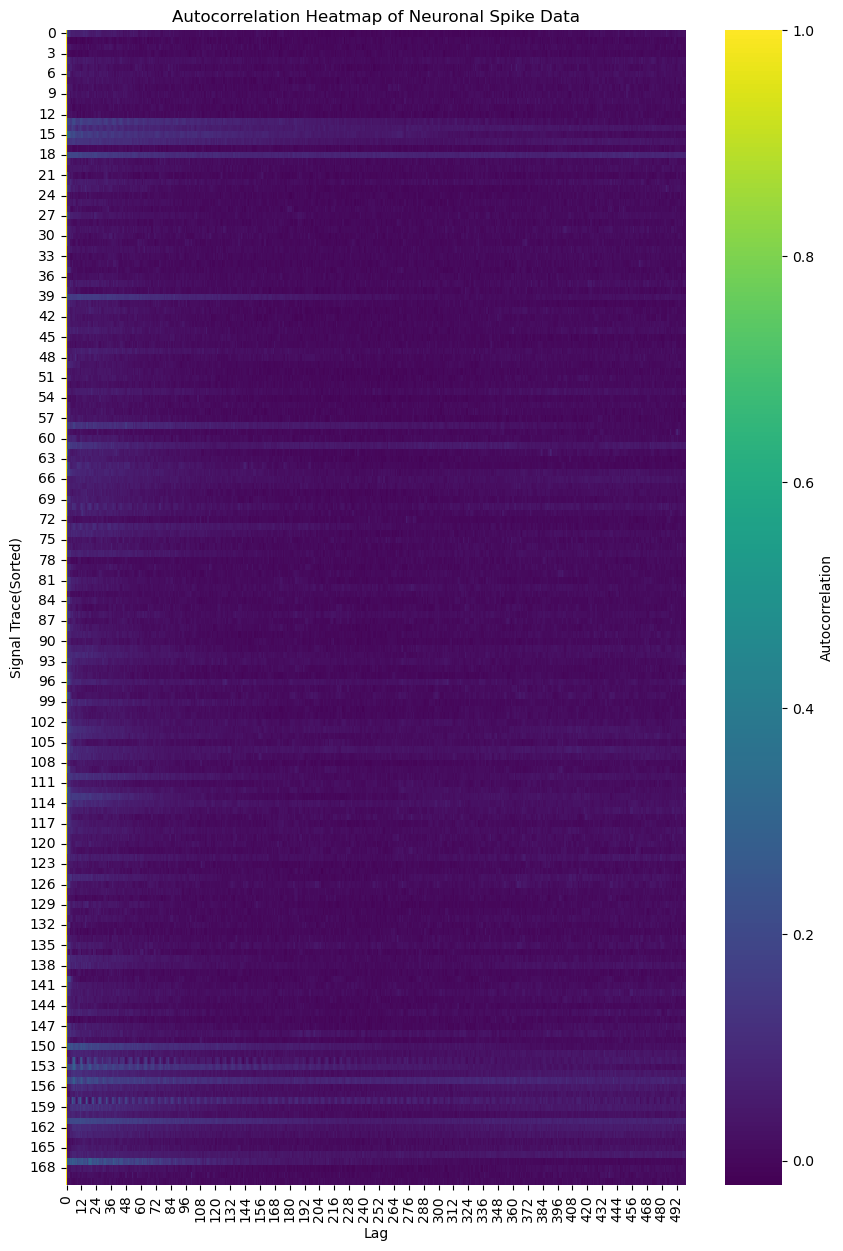

In [67]:
spks_df = notmoving_spks
autocorrelations = []
max_lag_positions = []
# Iterate over each row (each signal trace)
for index, row in spks_df.iterrows():
    # Convert the row to a NumPy array
    data = row.values

    # Compute the autocorrelation
    autocorr = np.correlate(data, data, mode="full")
    autocorr /= np.max(autocorr)  # Normalize
    autocorr = autocorr[len(autocorr) // 2 :]  # Take the second half
    autocorrelations.append(autocorr[:500])

    # Exclude the first lag (lag=0) when finding the max autocorrelation position
    max_lag_positions.append(
        np.argmax(autocorr[1:]) + 1
    )  # +1 to correct for the exclusion
# Sort the autocorrelations based on the lag position of the maximum autocorrelation value
sorted_indices = np.argsort(max_lag_positions)
sorted_autocorr_array = np.array(autocorrelations)[sorted_indices]


# Optional: Plot each autocorrelation
plt.figure(figsize=(10, 15))
sns.heatmap(
    sorted_autocorr_array, cmap="viridis", cbar_kws={"label": "Autocorrelation"}
)
plt.title("Autocorrelation Heatmap of Neuronal Spike Data")
plt.xlabel("Lag")
plt.ylabel("Signal Trace(Sorted)")
plt.show()

## Calculating PSD of the traces

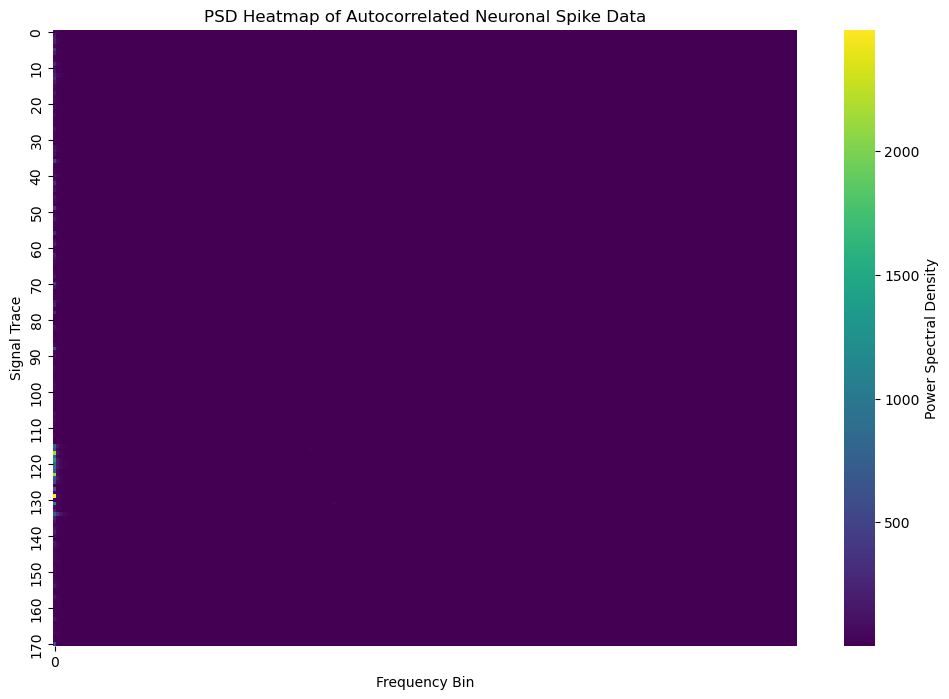

In [68]:
# Assuming autocorrelations is a list of numpy arrays containing the autocorrelation of each row
sampling_frequency = 20  # Sampling frequency in Hz
n = len(autocorrelations[0])  # Assuming all autocorrelations have the same length
freq_bins = np.fft.fftfreq(n, d=1.0 / sampling_frequency)

# Initialize an empty list to store the PSDs
psds = []

for autocorr in autocorrelations:
    psd = np.fft.fft(autocorr)
    psd = np.abs(psd) ** 2  # Power spectrum
    psds.append(psd[: n // 2])  # Keep only the first half

# Convert the list of PSDs into a 2D array
psd_array = np.array(psds)

# Plot the heatmap
plt.figure(figsize=(12, 8))
# Using seaborn
sns.heatmap(
    psd_array,
    cmap="viridis",
    xticklabels=250,
    yticklabels=10,
    cbar_kws={"label": "Power Spectral Density"},
)
plt.xlabel("Frequency Bin")
plt.ylabel("Signal Trace")
plt.title("PSD Heatmap of Autocorrelated Neuronal Spike Data")
plt.show()

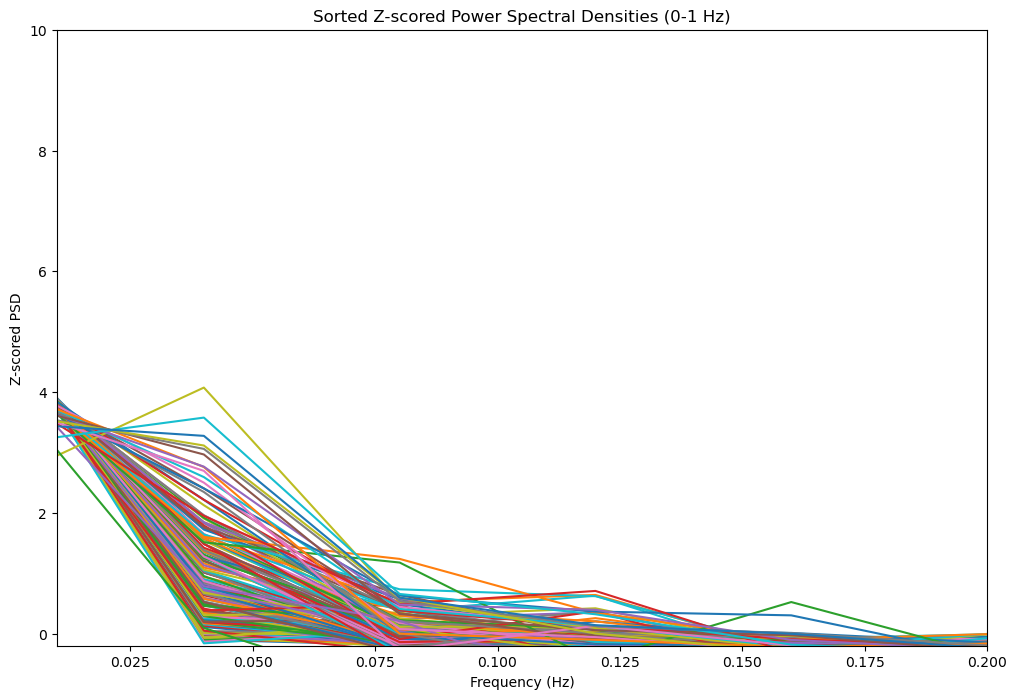

In [69]:
# Your sampling rate
sampling_rate = 20  # Replace with your actual sampling rate

# Length of the autocorrelation data
N = len(autocorrelations[0])

# Calculate the frequency values corresponding to FFT output
frequencies = np.fft.fftfreq(N, d=1 / sampling_rate)

# Indices for frequencies between 0 and 1 Hz
low_freq_indices = np.where((frequencies >= 0) & (frequencies <= 1))[0]

psd_list = []
for autocorr in autocorrelations:
    # Calculate the Fourier Transform
    psd = np.abs(fft(autocorr)) ** 2

    # Select the PSD components for 0-1 Hz
    psd_low_freq = psd[low_freq_indices]

    # Z-score normalization
    psd_z_scored = zscore(psd_low_freq)
    psd_list.append(psd_z_scored)

# Sorting based on the maximum power
psd_sorted = sorted(psd_list, key=lambda x: np.max(x), reverse=True)

# Plotting
plt.figure(figsize=(12, 8))
for psd in psd_sorted:
    plt.plot(
        frequencies[low_freq_indices], psd
    )  # Ensure the x-axis is using the selected frequencies
plt.title("Sorted Z-scored Power Spectral Densities (0-1 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Z-scored PSD")
plt.xlim(0.01, 0.2)  # Set x-axis limit to show only 0 to 1 Hz
plt.ylim(-0.2, 10)  # Set y-axis limit to show the PSDs
plt.show()

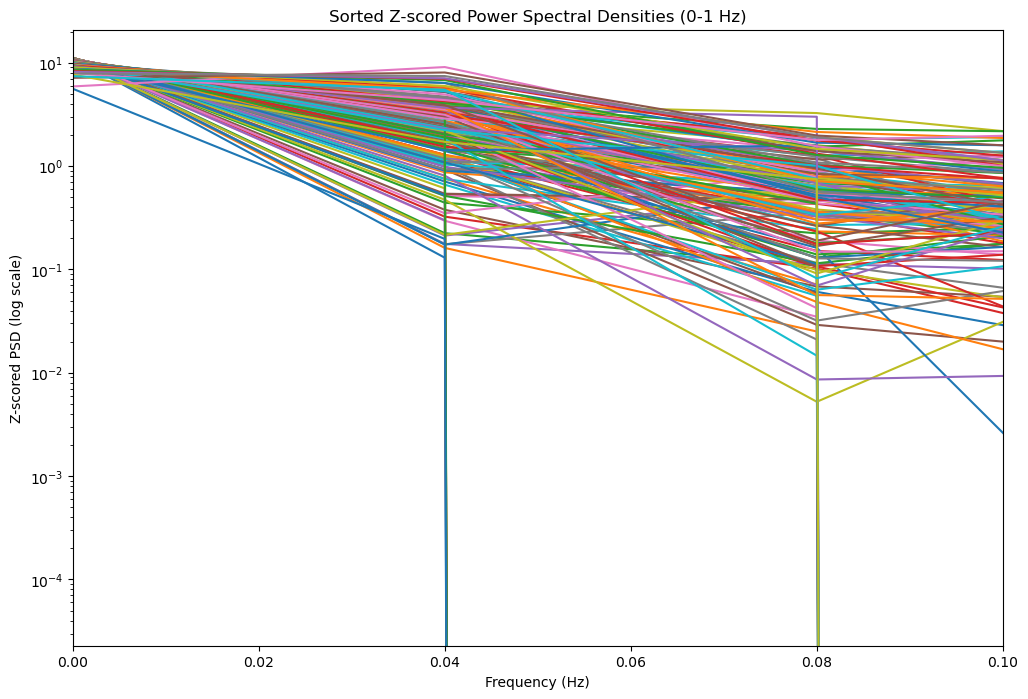

In [70]:
# Your sampling rate
sampling_rate = 20  # Replace with your actual sampling rate

# Length of the autocorrelation data
N = len(autocorrelations[0])

# Calculate the frequency values corresponding to FFT output
frequencies = np.fft.fftfreq(N, d=1 / sampling_rate)

# Indices for frequencies between 0 and 1 Hz
low_freq_indices = np.where((frequencies >= 0) & (frequencies <= 5))[0]

psd_list = []
for autocorr in autocorrelations:
    # Calculate the Fourier Transform
    psd = np.abs(fft(autocorr)) ** 2

    # Select the PSD components for 0-1 Hz
    psd_low_freq = psd[low_freq_indices]

    # Z-score normalization
    psd_z_scored = zscore(psd_low_freq)
    psd_list.append(psd_z_scored)

# Sorting based on the maximum power
psd_sorted = sorted(psd_list, key=lambda x: np.max(x), reverse=True)

# Plotting with semilogy
plt.figure(figsize=(12, 8))
for psd in psd_sorted:
    plt.semilogy(
        frequencies[low_freq_indices], psd
    )  # Use semilogy for logarithmic y-axis
plt.title("Sorted Z-scored Power Spectral Densities (0-1 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Z-scored PSD (log scale)")
plt.xlim(0, 0.1)  # Set x-axis limit to show only 0 to 1 Hz
plt.show()

Sliced PSDs ready for plotting.


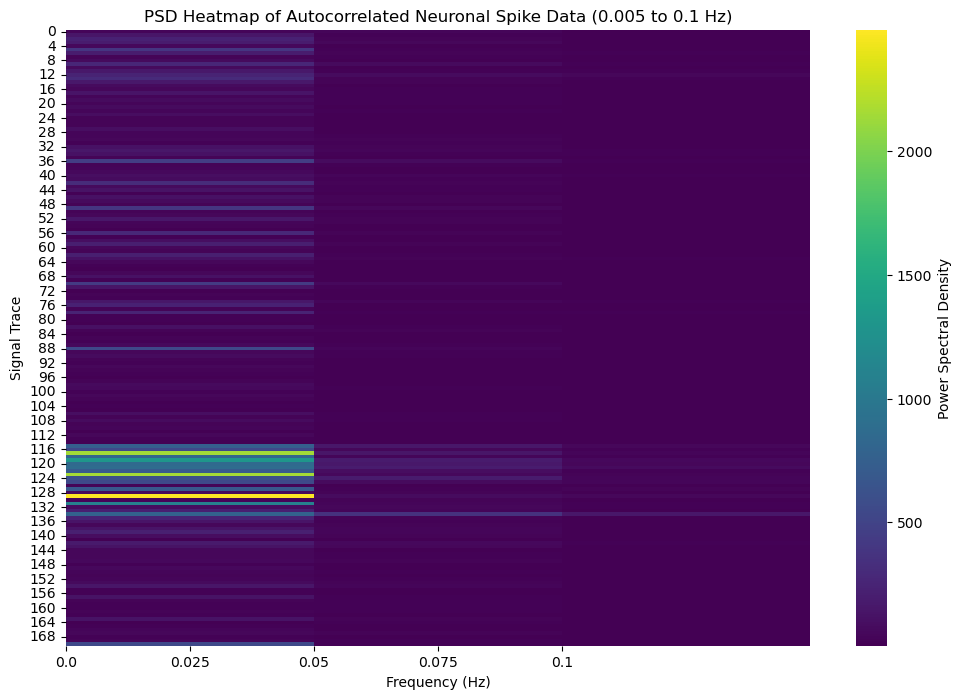

In [71]:
import numpy as np

# Given values
sampling_frequency = 20  # Hz
n = len(autocorrelations[0])  # Length of autocorrelation data

# Calculate frequency bins with correct resolution
freq_bins = np.fft.fftfreq(n, d=1.0 / sampling_frequency)

# Correctly identify indices for positive frequencies
positive_freq_indices = np.where(freq_bins > 0)[0]  # Only positive frequencies

# Find indices within the specified frequency range
min_freq = 0.00
max_freq = 0.1
desired_freq_indices = np.where((freq_bins >= min_freq) & (freq_bins <= max_freq))[0]

# If there are no indices found within the range, this indicates a potential issue
if len(desired_freq_indices) == 0:
    print(
        "No frequency bins found within the specified range. Consider checking the frequency range or the length of your data."
    )

# Assuming this part is correct, and you have PSDs calculated
# Ensure that you only use the positive frequency part for slicing
if len(desired_freq_indices) > 0:
    sliced_psds = [
        psd[desired_freq_indices]
        for psd in psds
        if len(psd) > max(desired_freq_indices)
    ]

    if not sliced_psds:
        print(
            "Sliced PSDs list is empty. Check if the PSD calculation or slicing went wrong."
        )
    else:
        # Continue with plotting as before, ensuring sliced_psds is not empty
        print("Sliced PSDs ready for plotting.")

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(sliced_psds, cmap="viridis", cbar_kws={"label": "Power Spectral Density"})
# Adjust the x-axis to show actual frequency values
plt.xticks(
    ticks=np.linspace(0, len(desired_freq_indices) - 1, 5),
    labels=np.round(np.linspace(min_freq, max_freq, 5), 3),
)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Signal Trace")
plt.title("PSD Heatmap of Autocorrelated Neuronal Spike Data (0.005 to 0.1 Hz)")
plt.show()